# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 

import os

In [2]:
import warnings
warnings.filterwarnings('ignore')  # Suprime todos los warnings

import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
import PIL
import os 
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
# from imblearn.over_sampling import SMOTE

# 1. Import data MRI

In [19]:
# Download dataset from kaggle
# Make sure you have a kaggle account and have downloaded your API, or download dataset from: 
# https://www.kaggle.com/datasets/ninadaithal/imagesoasis

!kaggle datasets download -d ninadaithal/imagesoasis

imagesoasis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
import zipfile

In [34]:
with zipfile.ZipFile('imagesoasis.zip', 'r') as zip_ref:
     zip_ref.extractall('imagesoasis')

In [3]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('./imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [4]:
images = []
labels = []
for subfolder in tqdm(os.listdir('./imagesoasis')):
    subfolder_path = os.path.join('./imagesoasis', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


,image,label
0,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Mild Dementia
1,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Mild Dementia
2,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Mild Dementia
3,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Mild Dementia
4,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Mild Dementia
...,...,...
86432,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Very mild Dementia
86433,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Very mild Dementia
86434,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Very mild Dementia
86435,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Very mild Dementia


# 2. Visualizing Data

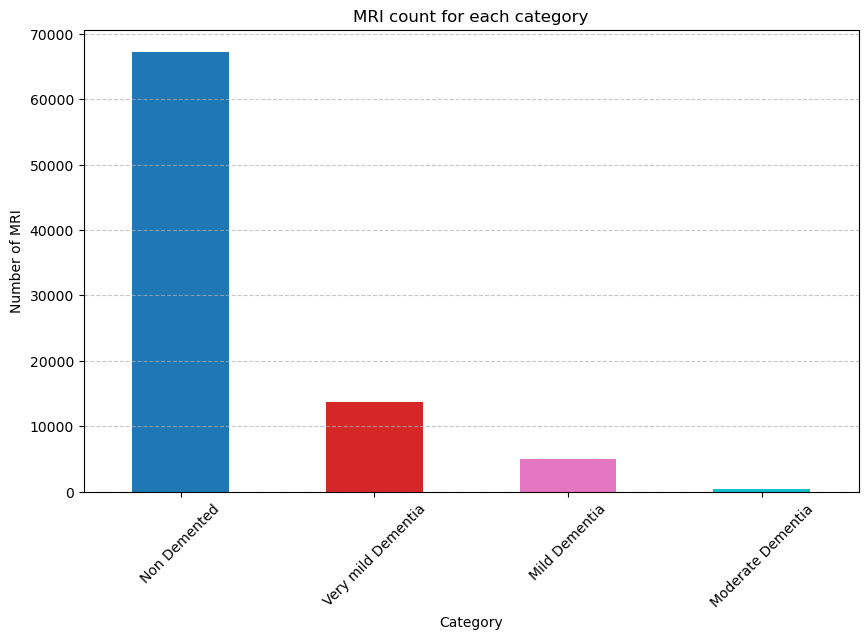

In [5]:
image_counts = df['label'].value_counts()

# colors
colors = plt.cm.get_cmap('tab10', len(image_counts))  # Usa el mapa de colores 'tab10'

plt.figure(figsize=(10, 6))
image_counts.plot(kind='bar', color=colors.colors)
plt.title('MRI count for each category')
plt.xlabel('Category')
plt.ylabel('Number of MRI')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It can be seen that we have unbalanced categories. The Non Demented category contains the largest number of images, while Moderate Dementia contains a small number of images. We can follow two different paths for classification. 
In a first approach, **two global categories are created**

In [5]:
# We create a df with binary categories

df_binary = df.copy()  # df copy
df_binary['label'] = df_binary['label'].replace({
    'Moderate Dementia': 'Demented',
    'Mild Dementia': 'Demented',
    'Very mild Dementia': 'Demented'
})

df_binary

,image,label
0,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Demented
1,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Demented
2,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Demented
3,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Demented
4,./imagesoasis\Data\Mild Dementia\OAS1_0028_MR1...,Demented
...,...,...
86432,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Demented
86433,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Demented
86434,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Demented
86435,./imagesoasis\Data\Very mild Dementia\OAS1_038...,Demented


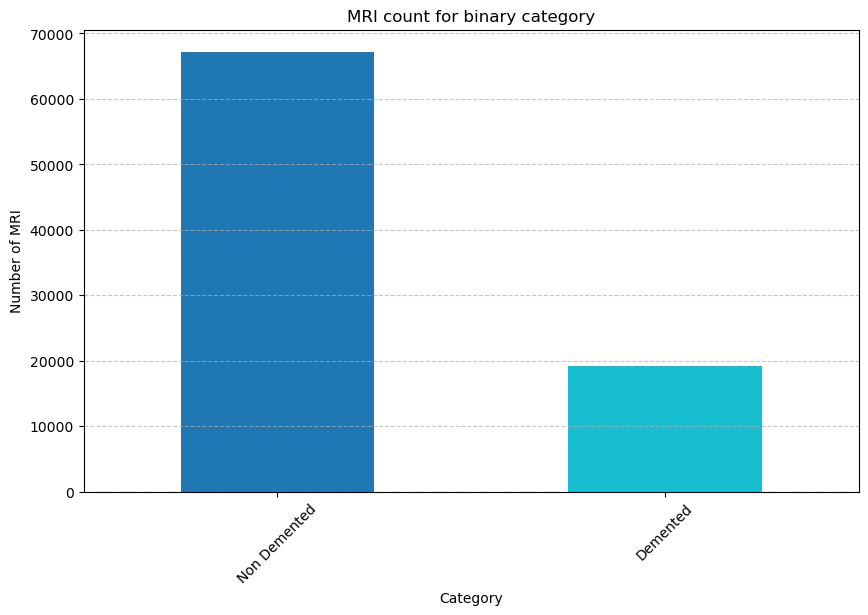

In [7]:
image_counts = df_binary['label'].value_counts()

# colors
colors = plt.cm.get_cmap('tab10', len(image_counts))  # Usa el mapa de colores 'tab10'

plt.figure(figsize=(10, 6))
image_counts.plot(kind='bar', color=colors.colors)
plt.title('MRI count for binary category')
plt.xlabel('Category')
plt.ylabel('Number of MRI')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Once again, an imbalance between classes is observed, although less than in the previous case. Two different processes will be followed when training and evaluating the network. 
**In a first approximation**, for both binary and multiclass classification, the number of images from the class with the lowest number of images will be selected. 
**In a second approximation**, for both binary and multiclass classification, oversampling will be done with **SMOTE**.

We visualize 5 images from each of the categories

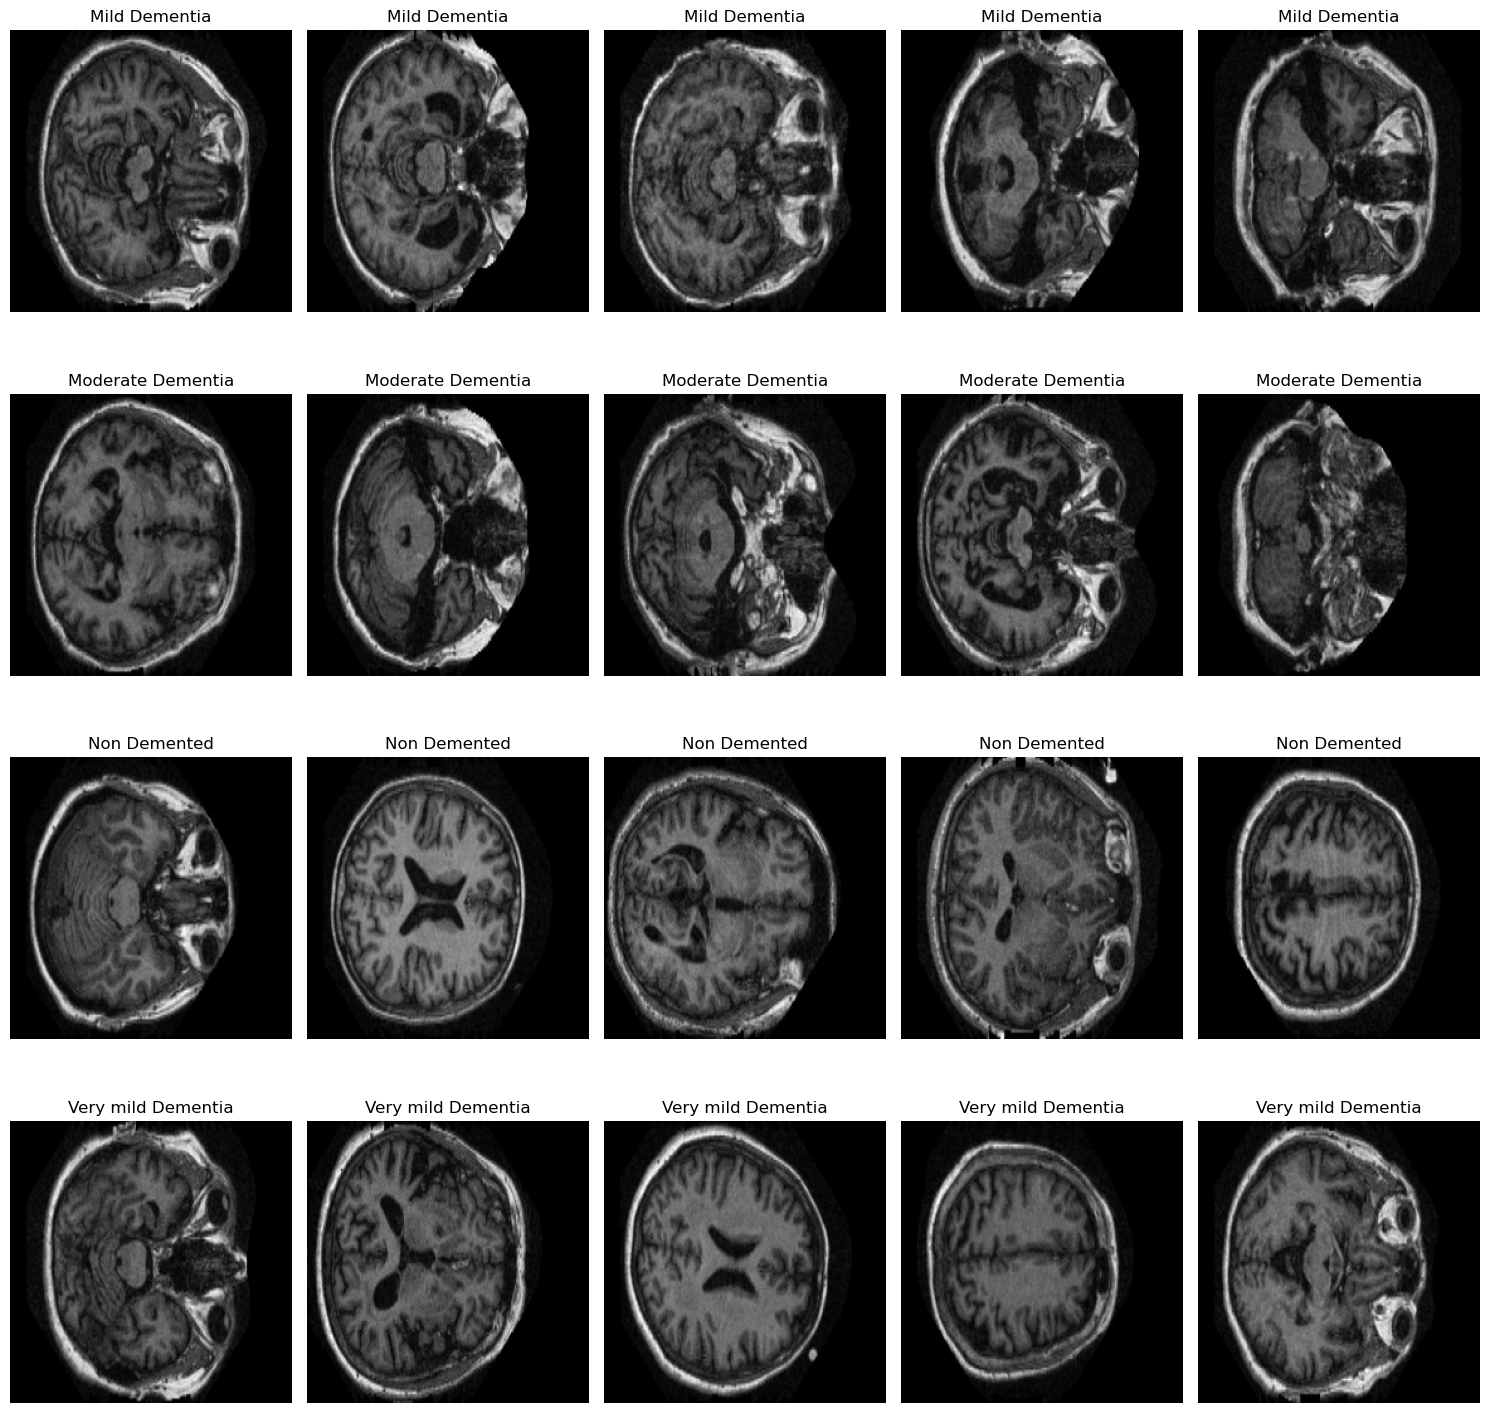

In [6]:

# group images for each category
categories = df['label'].unique()

plt.figure(figsize=(15, 15))
num_images = 5  # Number of images
i = 1  

for category in categories:
    
    category_images = df[df['label'] == category]['image']
    selected_images = np.random.choice(category_images, num_images, replace=False)
    
    for img_path in selected_images:

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        
        plt.subplot(len(categories), num_images, i)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()

In [11]:
print(len(non_demented))
print(len(mild_demented))
print(len(moderate_demented))
print(len(very_mild_demented))

67222
5002
488
13725


# 3. Data Proccessing

## 3.1 One Hot Encoding

In [6]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

0: **Non Demented** <br>
1: **Mild Dementia** <br>
2: **Moderate Dementia** <br>
3: **Very mild Dementia** <br>

## 3.2 Selecting images

**In a first approximation**, for both binary and multiclass classification, the number of images from the class with the lowest number of images will be selected. 

### **Multiclass Balanced (488 images)**

In [8]:
# Step 1: Group categories
non_demented_df = df[df['label'] == 'Non Demented']
mild_demented_df = df[df['label'] == 'Mild Dementia']
moderate_demented_df = df[df['label'] == 'Moderate Dementia']
very_mild_demented_df = df[df['label'] == 'Very mild Dementia']

# Step 2: Select 488
non_demented_sample = non_demented_df.sample(n=488, random_state=42)
mild_demented_sample = mild_demented_df.sample(n=488, random_state=42)
moderate_demented_sample = moderate_demented_df  # Esta ya tiene 488 imágenes
very_mild_demented_sample = very_mild_demented_df.sample(n=488, random_state=42)

# Step 3
df_balanced = pd.concat([non_demented_sample, mild_demented_sample, moderate_demented_sample, very_mild_demented_sample])
df_balanced = df_balanced.reset_index(drop=True)

print(df_balanced['label'].value_counts())

Non Demented          488
Mild Dementia         488
Moderate Dementia     488
Very mild Dementia    488
Name: label, dtype: int64


In [9]:
data = []  # list images
category = []  # list labels categories

# Iterar sobre el DataFrame
for index, row in tqdm(df_balanced.iterrows(), total=df_balanced.shape[0]):
    # Leer la imagen usando cv2
    img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (128, 128))  # Resize 128x128
    
    if img.shape == (128, 128):  
        data.append(img)  
        label_index = ['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very mild Dementia'].index(row['label'])
        category.append(encoder.transform([[label_index]]).toarray())  

# Convert to numpy
X = np.array(data)

100%|█████████████████████████████████████████████████████████████████████████████| 1952/1952 [00:02<00:00, 896.76it/s]


In [10]:
y=np.array(category)
print(y.shape) 

(1952, 1, 4)


In [11]:
y=np.array(category)
y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)

print(X.shape)  
print(y.shape)  

(1952, 128, 128)
(1952,)


### Binary Balanced (1464 images)

In [12]:
non_demented_dfb = df_binary[df_binary['label'] == 'Non Demented']
demented_dfb = df_binary[df_binary['label'] == 'Demented']

# Step 3: Select a sample of 488*3 from both classes
non_demented_sample_b = non_demented_dfb.sample(n=488*3, random_state=42)
demented_sample_b = demented_dfb.sample(n=488*3, random_state=42)

# Step 4: Combine both samples into a balanced dataset
dfb_balanced = pd.concat([non_demented_sample_b, demented_sample_b]).reset_index(drop=True)

# Step 5: Verify that both classes are balanced
print(dfb_balanced['label'].value_counts())

Non Demented    1464
Demented        1464
Name: label, dtype: int64


In [13]:
data_b = []  # list images
category_b = []  # list labels categories


for index, row in tqdm(dfb_balanced.iterrows(), total=dfb_balanced.shape[0]):
    
    img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (128, 128))  
    
    if img.shape == (128, 128):  
        data_b.append(img) 
        category_b.append(row['label'])  

# Convert to numpy
X_binary = np.array(data_b)

100%|████████████████████████████████████████████████████████████████████████████| 2928/2928 [00:02<00:00, 1354.31it/s]


In [14]:
encoder = LabelEncoder()

y_binary = encoder.fit_transform(category_b)

In [15]:
print(X_binary.shape) 
print(y_binary.shape) 

(2928, 128, 128)
(2928,)


## 3.3 Oversampling

### Multiclass SMOTE

We take 5002 images from all categories, which is the number of images from the second category with less images: mild demented. Then we make oversmapling of moderate demented, which contains only 488 images

In [9]:
# Step 1: Group categories
non_demented_df = df[df['label'] == 'Non Demented']
mild_demented_df = df[df['label'] == 'Mild Dementia']
moderate_demented_df = df[df['label'] == 'Moderate Dementia']
very_mild_demented_df = df[df['label'] == 'Very mild Dementia']

# Step 2: Select 488
non_demented_sample = non_demented_df.sample(n=5002, random_state=42)
mild_demented_sample = mild_demented_df.sample(n=5002, random_state=42)
moderate_demented_sample = moderate_demented_df  # Esta ya tiene 488 imágenes
very_mild_demented_sample = very_mild_demented_df.sample(n=5002, random_state=42)

# Step 3
df_smote = pd.concat([non_demented_sample, mild_demented_sample, moderate_demented_sample, very_mild_demented_sample])
df_smote = df_smote.reset_index(drop=True)

print(df_smote['label'].value_counts())

Non Demented          5002
Mild Dementia         5002
Very mild Dementia    5002
Moderate Dementia      488
Name: label, dtype: int64


In [13]:
data = []  # list images
category = []  # list labels categories

# Iterar sobre el DataFrame
for index, row in tqdm(df_smote.iterrows(), total=df_smote.shape[0]):
    # Leer la imagen usando cv2
    img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (128, 128))  # Resize 128x128
    
    if img.shape == (128, 128):  
        data.append(img)  
        label_index = ['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very mild Dementia'].index(row['label'])
        category.append(encoder.transform([[label_index]]).toarray())  

# Convert to numpy
X_smote = np.array(data)

100%|███████████████████████████████████████████████████████████████████████████| 15494/15494 [00:16<00:00, 920.28it/s]


In [15]:
y_smote=np.array(category)
y_smote=y_smote.reshape(X_smote.shape[0],4)
y_smote=np.argmax(y_smote, axis=1)

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
# Reshape 
X_flat = X_smote.reshape(len(X_smote), -1)

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_flat, y_smote)

X_resampled = X_resampled.reshape(-1, 128, 128)

print(X_resampled.shape, y_resampled.shape)

(20008, 128, 128) (20008,)


# 4. Spliting Data

### Multiclass Balanced (488 images)

In [12]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=42, shuffle = True)

In [14]:
X_train.shape

(1561, 128, 128)

In [15]:
X_test.shape

(391, 128, 128)

### Binary Balanced (488 images)

In [16]:
X_binary_train, X_binary_test, y_binary_train, y_binary_test= train_test_split(X_binary, y_binary, test_size=0.2,
                                                                              random_state=42, shuffle = True)

In [18]:
X_binary_train.shape

(2342, 128, 128)

In [19]:
X_binary_test.shape

(586, 128, 128)

### Multiclass SMOTE

In [19]:
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE= train_test_split(X_resampled,y_resampled,
                                                                           test_size=0.2,random_state=42, shuffle = True)

In [20]:
X_train_SMOTE.shape

(16006, 128, 128)

In [21]:
X_test_SMOTE.shape

(4002, 128, 128)

### Binary SMOTE

In [19]:
X_train_SMOTEb, X_test_SMOTEb, y_train_SMOTEb, y_test_SMOTEb = train_test_split(X_resampled_b,y_resampled_b,
                                                                           test_size=0.2,random_state=42, shuffle = True)

In [20]:
X_train_SMOTEb.shape

(16006, 128, 128)

In [21]:
X_test_SMOTEb.shape

(4002, 128, 128)

# 5. Creating own Model

### Multiclass

In [22]:
model=Sequential()

In [23]:
model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,1)))

In [24]:
model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4,activation='softmax'))

In [25]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,518,340 (32.49 MB)

 Trainable params: 8,517,892 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [26]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
# if wanted to use
# from keras.callbacks import EarlyStopping

# early_stopping=EarlyStopping(
#    monitor="val_loss",
#    min_delta=0.00001,
#    patience=20,
#    verbose=0,
#    mode="auto",
#    baseline=None,
#    restore_best_weights=True,
#    start_from_epoch=0)
# 

### Binary

In [21]:
modelb=Sequential()

In [22]:
modelb.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,1)))

In [23]:
modelb.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
modelb.add(BatchNormalization())
modelb.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
modelb.add(Dropout(0.25))
modelb.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
modelb.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
modelb.add(BatchNormalization())
modelb.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
modelb.add(Dropout(0.25))
modelb.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
modelb.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
modelb.add(BatchNormalization())
modelb.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
modelb.add(Dropout(0.25))


modelb.add(Flatten())
modelb.add(Dense(256,activation='relu'))
modelb.add(Dropout(0.25))
modelb.add(Dense(1, activation='sigmoid'))

In [24]:
print(modelb.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,517,569 (32.49 MB)

 Trainable params: 8,517,121 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [25]:
modelb.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 6. Training Models

## 6.1 own CNN

### Multiclass Balanced

In [26]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20 #, callbacks=[early_stopping]
                   , batch_size=32)

NameError: name 'model' is not defined

In [21]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8352 - loss: 0.5915


[0.5321341753005981, 0.8465473055839539]

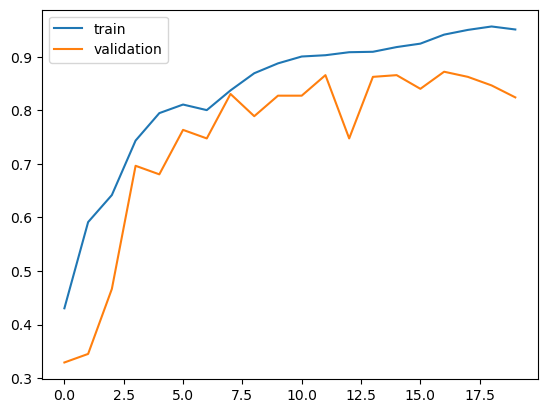

In [22]:
%matplotlib inline 
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

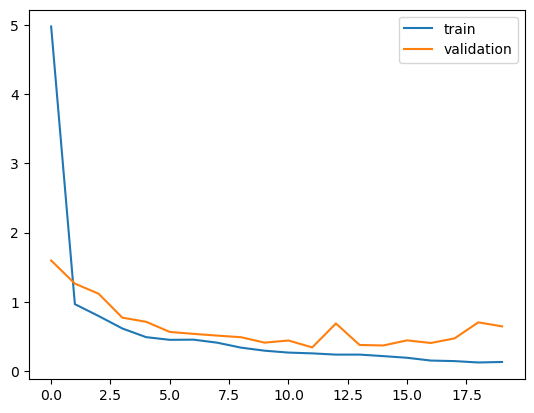

In [23]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [26]:
predicted_probabilities = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step


In [27]:
ypred = np.argmax(predicted_probabilities, axis=1)

In [28]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

accuracy_score(y_test, ypred)

0.8465473145780051

<Figure size 640x480 with 0 Axes>

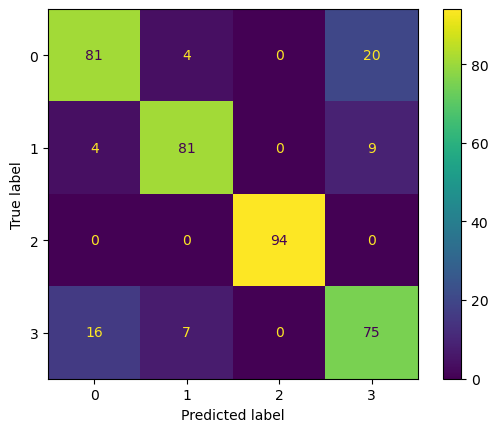

In [29]:
cf = confusion_matrix(y_true = y_test ,y_pred =  ypred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

x = ConfusionMatrixDisplay(cf)
x.plot()

In [30]:
print(classification_report(y_true = y_test ,y_pred =  ypred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79       105
           1       0.88      0.86      0.87        94
           2       1.00      1.00      1.00        94
           3       0.72      0.77      0.74        98

    accuracy                           0.85       391
   macro avg       0.85      0.85      0.85       391
weighted avg       0.85      0.85      0.85       391



### CNN Binary Balanced

In [27]:
history_binary = modelb.fit(X_binary_train, y_binary_train, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 739ms/step - accuracy: 0.5464 - loss: 6.1900 - val_accuracy: 0.4819 - val_loss: 1.0742
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 730ms/step - accuracy: 0.6011 - loss: 0.6394 - val_accuracy: 0.6290 - val_loss: 0.6614
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 737ms/step - accuracy: 0.7352 - loss: 0.5524 - val_accuracy: 0.6780 - val_loss: 0.5958
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 737ms/step - accuracy: 0.7880 - loss: 0.4567 - val_accuracy: 0.7271 - val_loss: 0.5800
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 728ms/step - accuracy: 0.8221 - loss: 0.3914 - val_accuracy: 0.6397 - val_loss: 0.6060
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 723ms/step - accuracy: 0.8050 - loss: 0.3901 - val_accuracy: 0.7271 - val_loss: 0.5300
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 723ms/step - accuracy: 0.8518 - loss: 0.3274 - val_accuracy: 0.7186 - val_loss: 0.7145
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 730ms/step - accuracy: 0.8840 - loss: 0.2780 - val_accu

In [28]:
modelb.evaluate(X_binary_test, y_binary_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.8564 - loss: 0.5386


[0.4326432943344116, 0.8754266500473022]

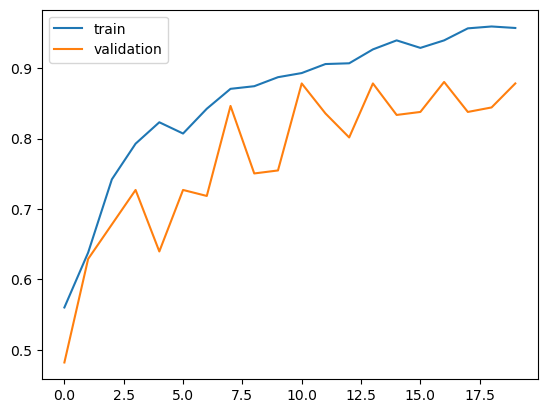

In [31]:
%matplotlib inline 
plt.plot(history_binary.history['accuracy'],label='train')
plt.plot(history_binary.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

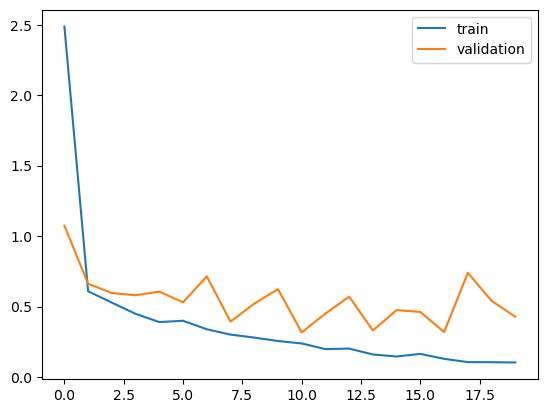

In [32]:
plt.plot(history_binary.history['loss'],label='train')
plt.plot(history_binary.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [38]:
predicted_binary = modelb.predict(X_binary_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


In [39]:

ypred_binary = (predicted_binary > 0.5).astype(int)

In [40]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

accuracy_score(y_binary_test, ypred_binary)

0.8754266211604096

<Figure size 640x480 with 0 Axes>

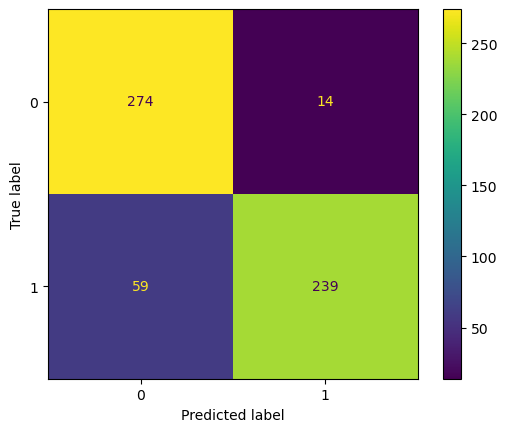

In [41]:
cf = confusion_matrix(y_true = y_binary_test ,y_pred =  ypred_binary)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

x = ConfusionMatrixDisplay(cf)
x.plot()

In [42]:
print(classification_report(y_true = y_binary_test ,y_pred =  ypred_binary))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       288
           1       0.94      0.80      0.87       298

    accuracy                           0.88       586
   macro avg       0.88      0.88      0.87       586
weighted avg       0.88      0.88      0.87       586



### Multiclass SMOTE

In [28]:
history_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE, validation_split=0.2, epochs=20 #, callbacks=[early_stopping]
                   , batch_size=128)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.5531 - loss: 0.9579 - val_accuracy: 0.5200 - val_loss: 1.1254
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.6766 - loss: 0.7368 - val_accuracy: 0.5109 - val_loss: 2.3547
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.7752 - loss: 0.5084 - val_accuracy: 0.6221 - val_loss: 0.8187
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8167 - loss: 0.4317 - val_accuracy: 0.7686 - val_loss: 0.5604
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.8548 - loss: 0.3477 - val_accuracy: 0.8941 - val_loss: 0.2805
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.8275 - loss: 0.4499 - val_accuracy: 0.9041 - val_loss: 0.2524
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.8555 - loss: 0.3607 - val_accuracy: 0.9300 - val_loss: 0.2063
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.8797 - loss: 0.3155 - val_accu

In [29]:
model.evaluate(X_test_SMOTE, y_test_SMOTE)

126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9821 - loss: 0.0476


[0.05356196314096451, 0.981509268283844]

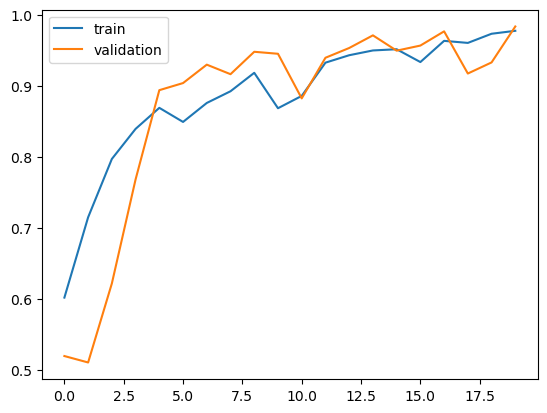

In [30]:
%matplotlib inline 
plt.plot(history_SMOTE.history['accuracy'],label='train')
plt.plot(history_SMOTE.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

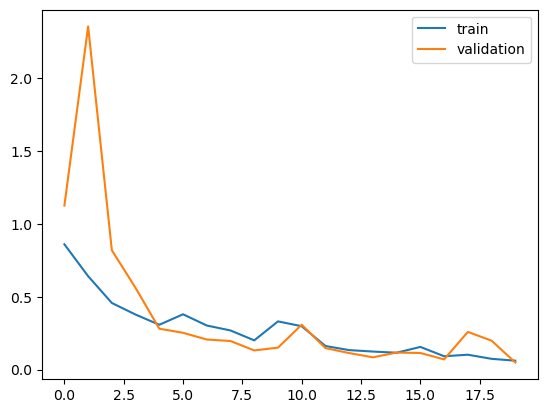

In [31]:
plt.plot(history_SMOTE.history['loss'],label='train')
plt.plot(history_SMOTE.history['val_loss'],label='validation')
plt.legend()
plt.show()

In [32]:
predicted_probabilities = model.predict(X_test_SMOTE)

126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step


In [33]:
ypred_SMOTE = np.argmax(predicted_probabilities, axis=1)

In [34]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

accuracy_score(y_test_SMOTE, ypred_SMOTE)

0.9815092453773113

<Figure size 640x480 with 0 Axes>

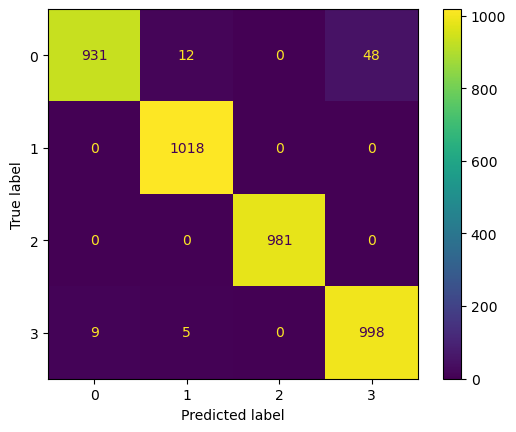

In [35]:
cf = confusion_matrix(y_true = y_test_SMOTE ,y_pred =  ypred_SMOTE)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

x = ConfusionMatrixDisplay(cf)
x.plot()

In [36]:
print(classification_report(y_true = y_test_SMOTE ,y_pred =  ypred_SMOTE))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       991
           1       0.98      1.00      0.99      1018
           2       1.00      1.00      1.00       981
           3       0.95      0.99      0.97      1012

    accuracy                           0.98      4002
   macro avg       0.98      0.98      0.98      4002
weighted avg       0.98      0.98      0.98      4002

